In [1]:
import cv2
import imutils #pip install imutils
import numpy as np
import cupy as cp
import random
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

random.seed(19)

%run ./variables.ipynb
%run ./utils.ipynb

In [18]:
def ret_img(DATASET_PATH, min_img=9, max_img=12):
    images = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f))]
    n = random.randint(min_img, max_img)
    tmp_images = []
    mean_brightness = 0
    for i in range(n):
        # CHOOSING RANDOM IMAGE
        img_path = random.choice(images)
        while(len(img_path.split('.'))<2 or img_path.split('.')[1]!='png'):
            img_path = random.choice(images)
        # LOADING THE IMAGE
        taxon = img_path.split('_')[1]
        img_path = join(DATASET_PATH, img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean_brightness += np.mean(img)
        
        tmp_images.append({"data":img, "taxon":taxon})
    mean_brightness /= len(tmp_images)
    return tmp_images

In [25]:
def rogn_img(tmp_images):
    #img_path = random.choice(images)
    tmp_images_rogn = []
    
    for img_obj in tmp_images:
        img = img_obj["data"]
        taxon = img_obj["taxon"]
        w, h = img.shape
        mask_rogn = round_rectangle(30, w, h, value=255)
        tmp_images_rogn.append({"data":img, "taxon":taxon,"mask_rogn":mask_rogn})
    return (tmp_images_rogn)

In [26]:
def raw_generation(tmp_images, simple_angles = True, size_px = 1000):
    art_img = (np.ones((size_px, size_px))).astype(np.uint8)
    global_patch = np.zeros_like(art_img)
    global_patch_mask = np.zeros_like(art_img)
    global_patch_mask_rogn = np.zeros_like(art_img)
    individual_masks = []
    labels = []
    for img_obj in tmp_images:
        img = img_obj["data"]
        mask_rogn = img_obj["mask_rogn"]
        mask = np.ones_like(img)*255
        # ROTATING
        if simple_angles:
            angle = random.choice((0,90))
        else:
            angle = random.randint(0,360)

        rotated = imutils.rotate_bound(img, angle)
        rotated_mask = imutils.rotate_bound(mask, angle)
        rotated_mask_rogn = imutils.rotate_bound(mask_rogn, angle)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        overlap_test = 1
        n_stop = 200
        while overlap_test != 0 and n_stop != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = random.randint(0,size_px-1), random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = np.zeros_like(art_img)
            patch_mask = np.zeros_like(art_img)
            patch_mask_rogn = np.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask_rogn[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask_rogn[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            #print(np.nonzero(np.logical_and(patch_mask, global_patch_mask)))
            overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask))[0])
            n_stop -= 1
        if n_stop > 0:
            # (erosion to get rid of black edges)
            kernel_size = 3
            kernel = np.ones((kernel_size,kernel_size),np.uint8)
            patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
            patch_mask_rogn = cv2.erode(patch_mask_rogn,kernel,iterations = 1)
            # filling global patches
            cv2.copyTo(patch, patch_mask, global_patch)
            cv2.copyTo(patch_mask, patch_mask, global_patch_mask)
            cv2.copyTo(patch_mask_rogn, patch_mask_rogn, global_patch_mask_rogn)
            patch_mask[patch_mask==255]=1.0
            individual_masks.append({
                "taxon": img_obj["taxon"],
                "patch_mask": patch_mask.astype(float)
            })
            labels.append({
                "taxon": img_obj["taxon"],
                "xmin": xmin+dxmin,
                "ymin": ymin+dymin,
                "xmax": xmax+dxmax,
                "ymax": ymax+dymax
                
            })
    #CREATING FINAL IMAGE
    cv2.copyTo(global_patch, global_patch_mask_rogn, art_img)
    return global_patch, global_patch_mask, global_patch_mask_rogn, labels, individual_masks

In [27]:
def img_filling(global_patch, global_patch_mask_rogn,sigma=10e3, verbose=False):
    final_img = global_patch.copy()
    acc, accw = np.zeros_like(final_img).astype(np.float64), np.zeros_like(final_img).astype(np.float64)
    # Finding contours
    # kernel_size = 5
    # kernel = np.ones((kernel_size,kernel_size),np.uint8)
    # mask_tmp = cv2.erode(global_patch_mask,kernel,iterations = 0)
    #showImg(global_patch_mask)
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    indices = np.indices(final_img.shape)
    xMap = indices[0]
    yMap = indices[1]
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        d2 = np.square(xMap - xkp) + np.square(yMap - ykp)
        w = np.exp(-d2/sigma)
        w[w<1e-10] = 1e-10
        acc += w*val
        accw += w
    acc = np.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    final_img[global_patch_mask_rogn==0]=acc_img[global_patch_mask_rogn==0]
    return final_img

In [35]:
def fast_img_filling(global_patch, global_patch_mask_rogn,sigma=10e3, verbose=False):
    final_img = cp.asarray(global_patch)
    # showImg(final_img)
    acc, accw = cp.zeros_like(final_img).astype(np.float64), cp.zeros_like(final_img).astype(np.float64)
    # Finding contours
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    indices = cp.indices(final_img.shape)
    xMap = indices[0]
    yMap = indices[1]
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        d2 = cp.square(xMap - xkp) + cp.square(yMap - ykp)
        w = cp.exp(-d2/sigma)
        w[w<1e-10] = 1e-10
        acc += w*val
        accw += w
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    tmp_global_patch_mask_null = cp.asarray(global_patch_mask_rogn)==0
    final_img[tmp_global_patch_mask_null]=acc_img[tmp_global_patch_mask_null]
    final_img = cp.asnumpy(final_img)
    return final_img

In [38]:
def Generator_Img(DATASET_PATH, simple_angles = False, size_px = 1000, fast=False, verbose=False):
    tmp_images = ret_img(DATASET_PATH, 9, 12)
    tmp_images_rogn = rogn_img(tmp_images)
    global_patch, global_patch_mask, global_patch_mask_rogn, labels, individual_masks = raw_generation(tmp_images_rogn, simple_angles = simple_angles, size_px = size_px) 
    
    if fast: final_image = fast_img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    else: final_image = img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    if verbose:
        print("Finished!")
        showImg(np.hstack([global_patch, global_patch_mask,global_patch_mask_rogn]))
        img_bb = final_image.copy()
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        for label in labels:
            img_bb = cv2.rectangle(img_bb, (label["ymin"], label["xmin"]), (label["ymax"], label["xmax"]), color, 4)
            img_bb = cv2.putText(img_bb,  label["taxon"], (label["ymin"], label["xmin"]), font, fontScale, color, 6, cv2.LINE_AA) 
        showImg(img_bb)
    return final_image, labels, individual_masks

0 / 6649
2000 / 6649
4000 / 6649
6000 / 6649
Finished!


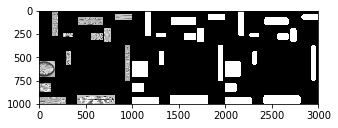

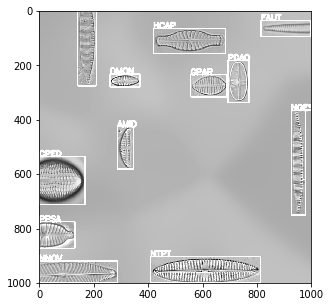

In [39]:
#final_img, labels = Generator_Img(DATASET_PATH = DATASET_PATH, simple_angles = True, size_px = 1000, fast=True, verbose=True)